# Proyecto RedCafe

En este notebook se documenta el proceso de obtención y consolidación de datos que serán analizados para el proyecto RedCafé.

## Obtención de datos

Para la obtención de datos, se realizan los siguientes pasos:

1. Para la variable de salida - NDVI - se obtienen los datos con una conexión a Google Earth Engine y una descarga desde MODIS/Terra.
2. Para las variables de entrada, la descarga de los datos se realiza directamente en los sitios web, y los datos son cargados desde archivos que están en el repositorio.

### Variable de Salida  - NDVI

En esta porción del cuaderno, se mantienen comentadas las celdas que conectan a Google Earth Engine y descargan los datos de NDVI.

In [1]:
# Librerías utilizadas

#!pip install earthengine-api
#!pip install geemap
#import ee
#import geemap.core as geemap
#import pandas as pd


In [2]:
#ee.Authenticate()
#ee.Initialize(project='ee-naranjocdaniela')


In [3]:
# ------------------------
# 1. Definir regiones de descarga
# ------------------------

regiones = {
    "Sierra Nevada": ee.Geometry.Polygon([
        [
            [-74.6, 10.2],
            [-73.5, 10.2],
            [-73.5, 11.5],
            [-74.6, 11.5],
            [-74.6, 10.2]
        ]
    ]),
    "Caldas": ee.Geometry.Polygon([
        [
            [-76.2, 4.7],
            [-74.9, 4.7],
            [-74.9, 5.7],
            [-76.2, 5.7],
            [-76.2, 4.7]
        ]
    ])
}

In [4]:
# Colección MODIS NDVI
#dataset = ee.ImageCollection('MODIS/061/MOD13Q1').select('NDVI')

In [8]:
# =========================
# Función para obtener NDVI mensual REAL
# =========================

def ndvi_mensual(region_name, geometry, start="2015-01-01", end="2024-12-31"):
    fechas = ee.DateRange(start, end)
    start_date = ee.Date(start)
    end_date = ee.Date(end)

    meses = ee.List.sequence(
        start_date.difference(end_date, 'month').abs().toInt(),
        0, -1
    ).map(lambda i: start_date.advance(i, 'month'))

    registros = []

    for i in range(meses.size().getInfo()):
        inicio_mes = ee.Date(meses.get(i))
        fin_mes = inicio_mes.advance(1, 'month')

        # COMPOSICIÓN MENSUAL CORRECTA
        img_mensual = dataset.filterDate(inicio_mes, fin_mes).mean()

        # Reducir NDVI para toda la región
        val = img_mensual.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=geometry,
            scale=250,
            maxPixels=1e13
        ).get('NDVI').getInfo()

        if val is not None:
            val = val * 0.0001

        mes_str = inicio_mes.format("YYYY-MM").getInfo()
        registros.append([region_name, mes_str, val])

    return pd.DataFrame(registros, columns=['Region', 'Mes', 'NDVI_mensual'])

In [10]:
# =========================
# 4. Obtener datos de cada región por separado
# =========================

#df_sierra_nevada = ndvi_mensual("Sierra Nevada", regiones["Sierra Nevada"])
#df_caldas         = ndvi_mensual("Caldas", regiones["Caldas"])

#print("Sierra Nevada:")
#print(df_sierra_nevada.head())

#print("\nCaldas:")
#print(df_caldas.head())

Sierra Nevada:
          Region      Mes  NDVI_mensual
0  Sierra Nevada  2024-12      0.769749
1  Sierra Nevada  2024-11      0.789129
2  Sierra Nevada  2024-10      0.755619
3  Sierra Nevada  2024-09      0.769197
4  Sierra Nevada  2024-08      0.780499

Caldas:
   Region      Mes  NDVI_mensual
0  Caldas  2024-12      0.629054
1  Caldas  2024-11      0.515116
2  Caldas  2024-10      0.616337
3  Caldas  2024-09      0.704665
4  Caldas  2024-08      0.779532


In [11]:
# # Guardar DataFrames como CSV
#df_sierra_nevada.to_csv('ndvi_SN.csv', index=False)
#df_caldas.to_csv('ndvi_Caldas.csv', index=False)

### Variables de entrada - TerraClimate

En esta porción del cuaderno se incluye el código con el que se transformaron los archivos de TerraClimate en CSV. Esta porción se procesó de forma independiente, por eso las celdas salen sin ejecución. Los datos tienen un peso mayor a 10GB, que impiden su carga a servicios en nube gratuitos y a GitHub.

In [ ]:
files = sorted(glob.glob("TerraClimate_*.nc"))
len(files), files[:10]

In [ ]:
variables = sorted(set(re.findall(r"TerraClimate_(.*?)_", f)[0] for f in files))
variables

In [ ]:
ruta_depto = "SHP_MGN2018_INTGRD_DEPTO/MGN_ANM_DPTOS.shp"
ruta_mpio  = "SHP_MGN2018_INTGRD_MPIO/MGN_ANM_MPIOS.shp"

deptos = gpd.read_file(ruta_depto)
mpios  = gpd.read_file(ruta_mpio)

# texto
mpios["DPTO_CCDGO"] = mpios["DPTO_CCDGO"].astype(str)
mpios["MPIO_CCDGO"] = mpios["MPIO_CCDGO"].astype(str)

caldas = mpios[mpios["DPTO_CCDGO"] == "17"].dissolve(by="DPTO_CCDGO")

santamarta = mpios[(mpios["DPTO_CCDGO"] == "47") & (mpios["MPIO_CCDGO"] == "001")]
cienaga    = mpios[(mpios["DPTO_CCDGO"] == "47") & (mpios["MPIO_CCDGO"] == "189")]

sierra = gpd.GeoDataFrame(pd.concat([santamarta, cienaga], ignore_index=True), crs=mpios.crs)

caldas.shape, sierra.shape

In [ ]:
def build_zone_all(zone_geom, zone_name, variables, years):

    dfs = []

    for year in years:
        v0 = variables[0]
        path0 = f"TerraClimate_{v0}_{year}.nc"
        ds0 = xr.open_dataset(path0).rio.write_crs("EPSG:4326")
        orig0 = list(ds0.data_vars)[0]

        ds_year = ds0[orig0].rio.clip(zone_geom, drop=True).to_dataset(name=v0)

        for v in variables[1:]:
            path = f"TerraClimate_{v}_{year}.nc"
            ds_v = xr.open_dataset(path).rio.write_crs("EPSG:4326")
            orig = list(ds_v.data_vars)[0]

            da_v = ds_v[orig].rio.clip(zone_geom, drop=True)
            ds_year[v] = da_v  # se alinea por time/lat/lon

        # --- Dataset completo
        df_year = ds_year.to_dataframe().reset_index()  # SIN dropna

        df_year["year"] = df_year["time"].dt.year
        df_year["month"] = df_year["time"].dt.month
        df_year["zone"] = zone_name

        dfs.append(df_year)

    return pd.concat(dfs, ignore_index=True)

In [ ]:
years = range(2015, 2025)
df_caldas_all = build_zone_all(caldas.geometry, "CALDAS", variables, years)
df_sierra_all = build_zone_all(sierra.geometry, "SIERRA", variables, years)

In [ ]:
df_caldas_all.shape, df_sierra_all.shape

In [ ]:
df1 = df_caldas_all.copy()
df2 =df_sierra_all.copy()

In [ ]:
porc_caldas = (df1.isna().mean() * 100).round(2).rename("Caldas_%")
porc_sierra = (df2.isna().mean() * 100).round(2).rename("Sierra_%")

na_porcentaje = pd.concat([porc_caldas, porc_sierra], axis=1)
display(na_porcentaje)

In [ ]:
df_caldas_all.head(5)

In [ ]:
df_caldas_final = (
    df_caldas_all
      .groupby(['year', 'month'])[variables]      # usar tu lista!
      .mean(numeric_only=True)
      .reset_index()
)

# Columna Mes: YYYY-MM
df_caldas_final["Mes"] = (
    df_caldas_final["year"].astype(str) + "-" +
    df_caldas_final["month"].astype(str).str.zfill(2)
)

# Columna Región
df_caldas_final["Region"] = "Caldas"

# Orden final como tu ejemplo
df_caldas_final = df_caldas_final[["Region", "Mes"] + variables]

In [ ]:
df_caldas_final.head(5)

In [ ]:
df_sierra_final = (
    df_sierra_all
      .groupby(['year', 'month'])[variables]
      .mean(numeric_only=True)
      .reset_index()
)

df_sierra_final["Mes"] = (
    df_sierra_final["year"].astype(str) + "-" +
    df_sierra_final["month"].astype(str).str.zfill(2)
)

df_sierra_final["Region"] = "Sierra Nevada"

df_sierra_final = df_sierra_final[["Region", "Mes"] + variables]


In [ ]:
df_caldas_final.to_csv("caldas_terraclimate.csv", index=False)
df_sierra_final.to_csv("sierra_nevada_terraclimate.csv", index=False)

### Carga de los datos desde archivos locales

Los archivos que se cargan aquí corresponden a:
- Variable de salida: dos archivos CSV: ndvi_SN.csv y df_caldas.csv, que ya tienen el formato ajustado.
- Variables de entrada Giovanni: TemperaturaSuperficialSueloSierra.nc y TemperaturaSuperficialSueloCaldas.nc
- Variables de entrada TerraClimate: caldas_terraclimate.csv y sierra_nevada_terraclimate.csv

In [51]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#### NDVI

Esta variable no requiere ajustes adicionales antes de ser consolidada con las demás variables.

In [52]:
df_NVDICaldas=pd.read_csv("ndvi_Caldas.csv")
df_NVDISierra=pd.read_csv("ndvi_SN.csv")

#### Temperatura Superficial del Suelo - Giovanni (NASA)

A esta variable se le realizan los siguientes ajustes:
- Dado que el archivo exportado incluye columnas propias de la estructura del NetCDF como 'bnds' y 'time_bnds', estas fueron eliminadas junto con las filas duplicadas asociadas a dichas bandas temporales.
- La variable de Temperatura Superficial estaba originalmente en grados Kelvin, y fue convertida a grados Celsius (°C) para facilitar su interpretación agroclimática.


In [53]:
ds_caldas = xr.open_dataset("TemperauraSuperficialSueloCaldas.nc")
ds_sierra = xr.open_dataset("TemperaturaSuperficialSueloSierra.nc")

df_TScaldas = ds_caldas.to_dataframe().reset_index()
df_TSsierra = ds_sierra.to_dataframe().reset_index()

In [54]:
df_TScaldas.head(4)

time  bnds  GLDAS_NOAH10_M_2_1_AvgSurfT_inst  datamonth  time_bnds
0 2015-01-01     0                        290.615631     201501 2015-01-01
1 2015-01-01     1                        290.615631     201501 2015-02-01
2 2015-02-01     0                        291.294617     201502 2015-02-01
3 2015-02-01     1                        291.294617     201502 2015-03-01

In [55]:
# Cambiamos el nombre de la variable para un mejor manejo ---
varname = "GLDAS_NOAH10_M_2_1_AvgSurfT_inst"
df_TScaldas = df_TScaldas.rename(columns={varname: "TS"})
df_TSsierra = df_TSsierra.rename(columns={varname: "TS"})

In [56]:
# ================================================
# Conversión de Temperatura Superficial del Suelo (K → °C)
# y cálculo de promedios mensuales para Caldas y Sierra Nevada
# ================================================

# Convertimos TS de Kelvin a °C ---
def convert_to_celsius(df, variable):
    df['TS_C'] = df[variable] - 273.15
    return df

df_TScaldas = convert_to_celsius(df_TScaldas, "TS")
df_TSsierra = convert_to_celsius(df_TSsierra, "TS")

In [57]:
#Eliminamos las variables 'bnds' y 'time_bnds', ya que no representan información adicional y solo marcan el inicio y el final del mes
df_TScaldas = df_TScaldas.drop(columns=['bnds', 'time_bnds', 'datamonth'])
df_TSsierra = df_TSsierra.drop(columns=['bnds', 'time_bnds', 'datamonth'])

In [58]:
df_TScaldas['time'] = pd.to_datetime(df_TScaldas['time'])
df_TSsierra['time'] = pd.to_datetime(df_TSsierra['time'])

df_TScaldas = df_TScaldas[df_TScaldas['time'].dt.year != 2025]
df_TSsierra = df_TSsierra[df_TSsierra['time'].dt.year != 2025]

In [59]:
df_TScaldas = df_TScaldas.drop_duplicates(subset=['time'])
df_TSsierra = df_TSsierra.drop_duplicates(subset=['time'])

df_TScaldas.head()

time          TS       TS_C
0 2015-01-01  290.615631  17.465637
2 2015-02-01  291.294617  18.144623
4 2015-03-01  291.690796  18.540802
6 2015-04-01  291.373413  18.223419
8 2015-05-01  291.626862  18.476868

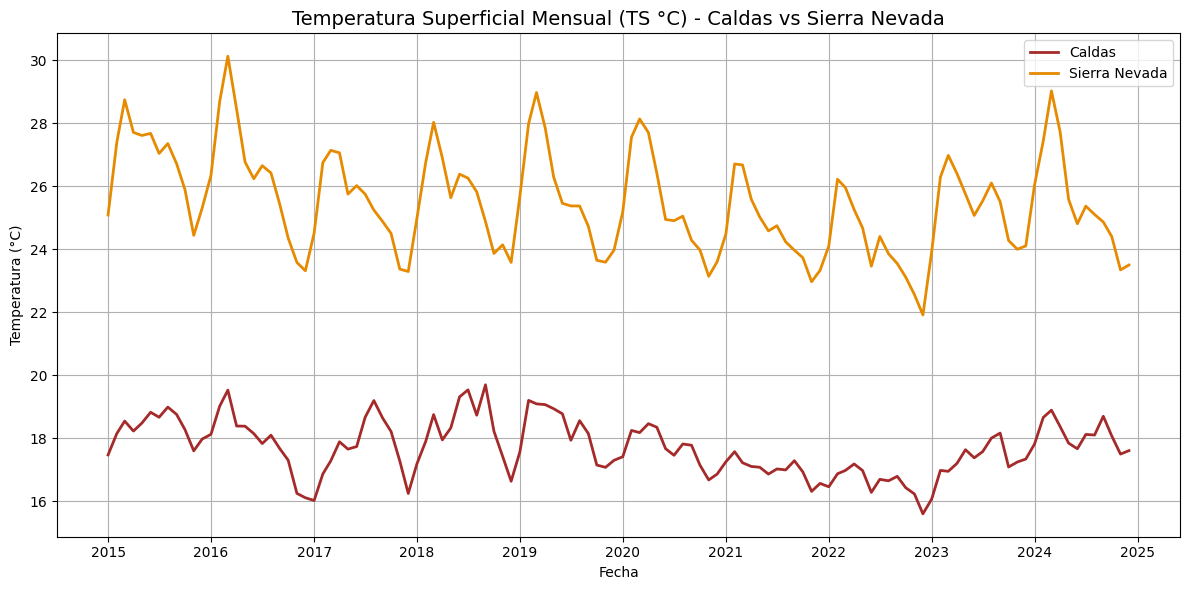

In [60]:
#Comparamos la variable mensual de las dos zonas
plt.figure(figsize=(12,6))

plt.plot(df_TScaldas['time'], df_TScaldas['TS_C'], label='Caldas', linewidth=2, color='#A52A2A')
plt.plot(df_TSsierra['time'], df_TSsierra['TS_C'], label='Sierra Nevada', linewidth=2, color='#E68A00')

plt.title('Temperatura Superficial Mensual (TS °C) - Caldas vs Sierra Nevada', fontsize=14)
plt.xlabel('Fecha')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Variables obtenidas de TerraClimate (Climatology Lab)

In [61]:
df_caldas = pd.read_csv("caldas_terraclimate.csv", encoding="utf-8")
df_sierra = pd.read_csv("sierra_nevada_terraclimate.csv", encoding="utf-8")

print("registros: df_caldas", df_caldas.shape[0])
print("registros: df_sierra", df_sierra .shape[0])


registros: df_caldas 120
registros: df_sierra 120


In [62]:
df_caldas.head(3)

Region      Mes      PDSI         aet       def         pet         ppt  \
0  Caldas  2015-01 -0.791719  105.327221  5.857307  111.184527  108.258166   
1  Caldas  2015-02 -0.775731   92.085387  6.577077   98.662464  106.961032   
2  Caldas  2015-03  0.988052  106.169341  0.000000  106.169341  213.370201   

           q       soil        srad       swe       tmax       tmin       vap  \
0  12.956160  44.142407  225.085100  0.000000  24.635444  15.462808  1.965656   
1  18.188539  40.826361  214.428367  0.000000  24.264097  16.361891  2.017504   
2  93.920344  54.104871  202.961605  0.001146  24.396791  16.022149  1.990897   

        vpd        ws  
0  0.612722  1.211948  
1  0.581003  1.281862  
2  0.592980  1.101146

### Consolidación de la base de datos

In [63]:
df_NVDICaldas = df_NVDICaldas.rename(columns={"Mes": "time"})
df_NVDISierra = df_NVDISierra.rename(columns={"Mes": "time"})
df_sierra = df_sierra.rename(columns={"Mes": "time"})
df_caldas = df_caldas.rename(columns={"Mes": "time"})

In [64]:
df_NVDICaldas = df_NVDICaldas.drop(
    ['Region'],
    axis=1
)
df_NVDISierra = df_NVDISierra.drop(
    ['Region'],
    axis=1
)

df_caldas = df_caldas.drop(
    ['Region'],
    axis=1
)
df_sierra = df_sierra.drop(
    ['Region'],
    axis=1
)

df_TScaldas = df_TScaldas.drop(
    ['TS'],
    axis=1
)
df_TSsierra = df_TSsierra.drop(
    ['TS'],
    axis=1
)

In [65]:
print(df_NVDICaldas.shape)
print(df_TScaldas.shape)
print(df_caldas.shape)

(120, 2)
(120, 2)
(120, 15)


In [66]:
df_NVDICaldas['time'] = pd.to_datetime(df_NVDICaldas['time'])
df_TScaldas['time'] = pd.to_datetime(df_TScaldas['time'])
df_caldas['time'] = pd.to_datetime(df_caldas['time'])
df_NVDISierra['time'] = pd.to_datetime(df_NVDISierra['time'])
df_TSsierra['time'] = pd.to_datetime(df_TSsierra['time'])
df_sierra['time'] = pd.to_datetime(df_sierra['time'])


In [67]:
df_caldas_union = (
    df_NVDICaldas
        .merge(df_caldas, on="time", how="outer")
        .merge(df_TScaldas, on="time", how="outer")
)

In [68]:
# Aplicamos un formato a la tabla para una mejor visualización
numeric_cols = df_caldas_union.select_dtypes(include='number').columns.tolist()
numeric_cols = [c for c in numeric_cols if c != "time"]
format_dict = {col: "{:.2f}" for col in numeric_cols}
format_dict["time"] = lambda t: t.strftime("%Y-%m-%d")

# Mostrar tabla con formato aplicado
df_caldas_union.head(4).style.format(format_dict)

In [69]:
df_sierra_union = (
    df_NVDISierra
        .merge(df_sierra, on="time", how="outer")
        .merge(df_TSsierra, on="time", how="outer")
)

In [70]:
# Aplicamos un formato a la tabla para una mejor visualización
numeric_cols = df_sierra_union.select_dtypes(include='number').columns.tolist()
numeric_cols = [c for c in numeric_cols if c != "time"]
format_dict = {col: "{:.2f}" for col in numeric_cols}
format_dict["time"] = lambda t: t.strftime("%Y-%m-%d")

# Mostrar tabla con formato aplicado
df_sierra_union.head(4).style.format(format_dict)

### Evaluación de la calidad de los datos

In [71]:
#Creamos una función para hacer un análisis rápido de cada dataset
def quality_report(df, name="Dataset", expected_ranges=None):

    print(f"\n===== REPORTE DE CALIDAD: {name} =====\n")

    print(f"Total de filas: {len(df)}\n")

    # -------------------------
    # 1. Valores faltantes
    # -------------------------
    print("➤ Valores faltantes por variable:")
    print(df.isna().sum())
    print("\n")

    # -------------------------
    # 2. Duplicados por variable
    # -------------------------
    print("➤ Duplicados por variable:")
    for col in df.columns:
        dups = df[col].duplicated().sum()
        print(f"  {col}: {dups}")
    print("\n")

    # -------------------------
    # 3. Outliers (IQR)
    # -------------------------
    print("➤ Outliers detectados por IQR (±1.5 IQR):")
    outlier_report = {}

    for col in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        n_outliers = df[(df[col] < lower) | (df[col] > upper)][col].count()
        outlier_report[col] = n_outliers

        print(f"  {col}: {n_outliers} outliers (rango IQR: {lower:.2f} – {upper:.2f})")

    print("\n")

    # -------------------------
    # 4. Validación de rango esperado
    # -------------------------
    if expected_ranges:
        print("➤ Valores fuera del rango esperado:")
        for col, (low, high) in expected_ranges.items():
            if col in df.columns:
                outside = df[(df[col] < low) | (df[col] > high)][col].count()
                print(f"  {col}: {outside} fuera del rango ({low} – {high})")
            else:
                print(f"  {col}: ❗ No está en el dataframe.")
    else:
        print("⚠ No se proporcionó diccionario de rangos esperados.")

    print("\n===== FIN DEL REPORTE =====\n")

In [72]:
expected_ranges = {
    "NDVI_mensual": (-1, 1),
    "TS_C": (10, 30),
    "aet": (40, 150),
    "pet": (70, 220),
    "def": (-50, 100),
    "ppt": (0, 400),
    "q": (150, 200),
    "soil": (0.15, 0.35),
    "srad": (180, 300),
    "swe": (0, 0),
    "tmax": (22, 34),
    "tmin": (10, 18),
    "vap": (1, 2.4),
    "ws": (1, 3),
    "vpd": (0.8, 1.6),
    "PDSI": (-2, 2)
}

In [73]:
quality_report(df_sierra_union, name="Region Sierra Nevada", expected_ranges=expected_ranges)


===== REPORTE DE CALIDAD: Region Sierra Nevada =====

Total de filas: 120

➤ Valores faltantes por variable:
time            0
NDVI_mensual    0
PDSI            0
aet             0
def             0
pet             0
ppt             0
q               0
soil            0
srad            0
swe             0
tmax            0
tmin            0
vap             0
vpd             0
ws              0
TS_C            0
dtype: int64


➤ Duplicados por variable:
  time: 0
  NDVI_mensual: 0
  PDSI: 0
  aet: 0
  def: 8
  pet: 0
  ppt: 0
  q: 0
  soil: 0
  srad: 0
  swe: 85
  tmax: 1
  tmin: 2
  vap: 1
  vpd: 1
  ws: 1
  TS_C: 1


➤ Outliers detectados por IQR (±1.5 IQR):
  NDVI_mensual: 0 outliers (rango IQR: 0.55 – 0.85)
  PDSI: 0 outliers (rango IQR: -10.39 – 7.14)
  aet: 0 outliers (rango IQR: -17.06 – 183.93)
  def: 0 outliers (rango IQR: -78.18 – 159.68)
  pet: 3 outliers (rango IQR: 91.59 – 159.31)
  ppt: 1 outliers (rango IQR: -211.81 – 397.07)
  q: 14 outliers (rango IQR: -39.66 – 68.31)


In [74]:
quality_report(df_caldas_union, name="Region Caldas", expected_ranges=expected_ranges)


===== REPORTE DE CALIDAD: Region Caldas =====

Total de filas: 120

➤ Valores faltantes por variable:
time            0
NDVI_mensual    0
PDSI            0
aet             0
def             0
pet             0
ppt             0
q               0
soil            0
srad            0
swe             0
tmax            0
tmin            0
vap             0
vpd             0
ws              0
TS_C            0
dtype: int64


➤ Duplicados por variable:
  time: 0
  NDVI_mensual: 0
  PDSI: 0
  aet: 0
  def: 44
  pet: 1
  ppt: 0
  q: 0
  soil: 34
  srad: 0
  swe: 97
  tmax: 0
  tmin: 0
  vap: 0
  vpd: 0
  ws: 2
  TS_C: 0


➤ Outliers detectados por IQR (±1.5 IQR):
  NDVI_mensual: 0 outliers (rango IQR: 0.41 – 0.84)
  PDSI: 0 outliers (rango IQR: -8.19 – 4.81)
  aet: 4 outliers (rango IQR: 69.08 – 123.13)
  def: 20 outliers (rango IQR: -6.28 – 10.47)
  pet: 4 outliers (rango IQR: 77.71 – 122.02)
  ppt: 0 outliers (rango IQR: -34.87 – 374.07)
  q: 1 outliers (rango IQR: -116.70 – 246.58)
  soil: 

### Descripción de estadísticas básicas

In [75]:
df_caldas_union.drop(['time'], axis=1).describe()

NDVI_mensual        PDSI         aet         def         pet  \
count    120.000000  120.000000  120.000000  120.000000  120.000000   
mean       0.623467   -1.581434   94.864678    6.099857  100.964491   
std        0.071184    2.131034   11.119819   13.307885    9.169233   
min        0.412798   -5.137880   52.903152    0.000000   82.626648   
25%        0.568568   -3.314542   89.347564    0.000000   94.325788   
50%        0.625909   -2.095745   96.781805    0.264040  100.480229   
75%        0.675309   -0.063675  102.860100    4.188754  105.401576   
max        0.779532    3.175645  111.949284   73.143553  128.687106   

              ppt           q        soil        srad         swe        tmax  \
count  120.000000  120.000000  120.000000  120.000000  120.000000  120.000000   
mean   167.931039   73.066332   46.528615  198.189140    0.002989   24.526622   
std     69.790760   61.794962   11.032570   17.750965    0.014088    0.878950   
min     31.953295    1.667335   15.019771  165.548711    0.000000   22.281948   
25%    118.483524   19.528653   42.161103  186.586891    0.000000   23.882593   
50%    160.762464   59.630372   52.588968  196.018338    0.000860   24.452865   
75%    220.716547  110.349642   54.173639  209.791977    0.001719   25.148424   
max    352.188825  265.759599   54.173639  249.249284    0.147278   26.227794   

             tmin         vap         vpd          ws        TS_C  
count  120.000000  120.000000  120.000000  120.000000  120.000000  
mean    15.966774    1.952676    0.648076    1.070977   17.706493  
std      0.634285    0.083472    0.165121    0.144779    0.873333  
min     14.402579    1.717610    0.299885    0.673926   15.593475  
25%     15.481032    1.901262    0.539563    0.980946   17.079796  
50%     15.935100    1.961678    0.633338    1.080372   17.662079  
75%     16.467407    2.002229    0.756562    1.181096   18.328835  
max     17.623496    2.192825    1.050143    1.468481   19.693176

In [76]:
df_sierra_union.drop(['time'], axis=1).describe()

NDVI_mensual        PDSI         aet         def         pet  \
count    120.000000  120.000000  120.000000  120.000000  120.000000   
mean       0.697791   -1.632843   83.495828   41.482329  124.977807   
std        0.054084    2.603801   27.949051   33.158554   12.972838   
min        0.552740   -7.443918   28.049123    0.000000   84.181287   
25%        0.661964   -3.818246   58.311404   11.018713  116.987865   
50%        0.711743   -1.389269   89.407602   38.629825  124.834795   
75%        0.736388    0.563377  108.559649   70.483333  133.918421   
max        0.789129    2.811579  131.784795  129.530994  157.580117   

              ppt           q        soil        srad         swe        tmax  \
count  120.000000  120.000000  120.000000  120.000000  120.000000  120.000000   
mean   108.511535   24.497734  234.038923  227.711213    0.009868   26.868328   
std     99.455804   38.826831   75.280278   19.530552    0.024691    0.818738   
min      0.097661    0.000000   75.561404  165.090643    0.000000   25.108187   
25%     16.520029    0.826170  180.255263  215.400731    0.000000   26.279240   
50%     97.752924    6.701754  228.626608  227.816959    0.001170   26.903216   
75%    168.741228   27.819737  290.857018  241.540497    0.006140   27.508333   
max    492.211696  191.432164  404.987719  277.315789    0.209942   28.921637   

             tmin         vap         vpd          ws        TS_C  
count  120.000000  120.000000  120.000000  120.000000  120.000000  
mean    17.297355    2.238944    0.700945    3.607945   25.492861  
std      0.897470    0.140217    0.119946    0.541168    1.608725  
min     14.830409    1.887421    0.410643    2.080468   21.913544  
25%     16.664605    2.157901    0.634327    3.283626   24.268150  
50%     17.446199    2.274865    0.713129    3.585380   25.373199  
75%     17.913889    2.335860    0.787120    3.993304   26.661514  
max     18.795322    2.502269    0.939942    4.774737   30.133514

### Correlación entre las variables

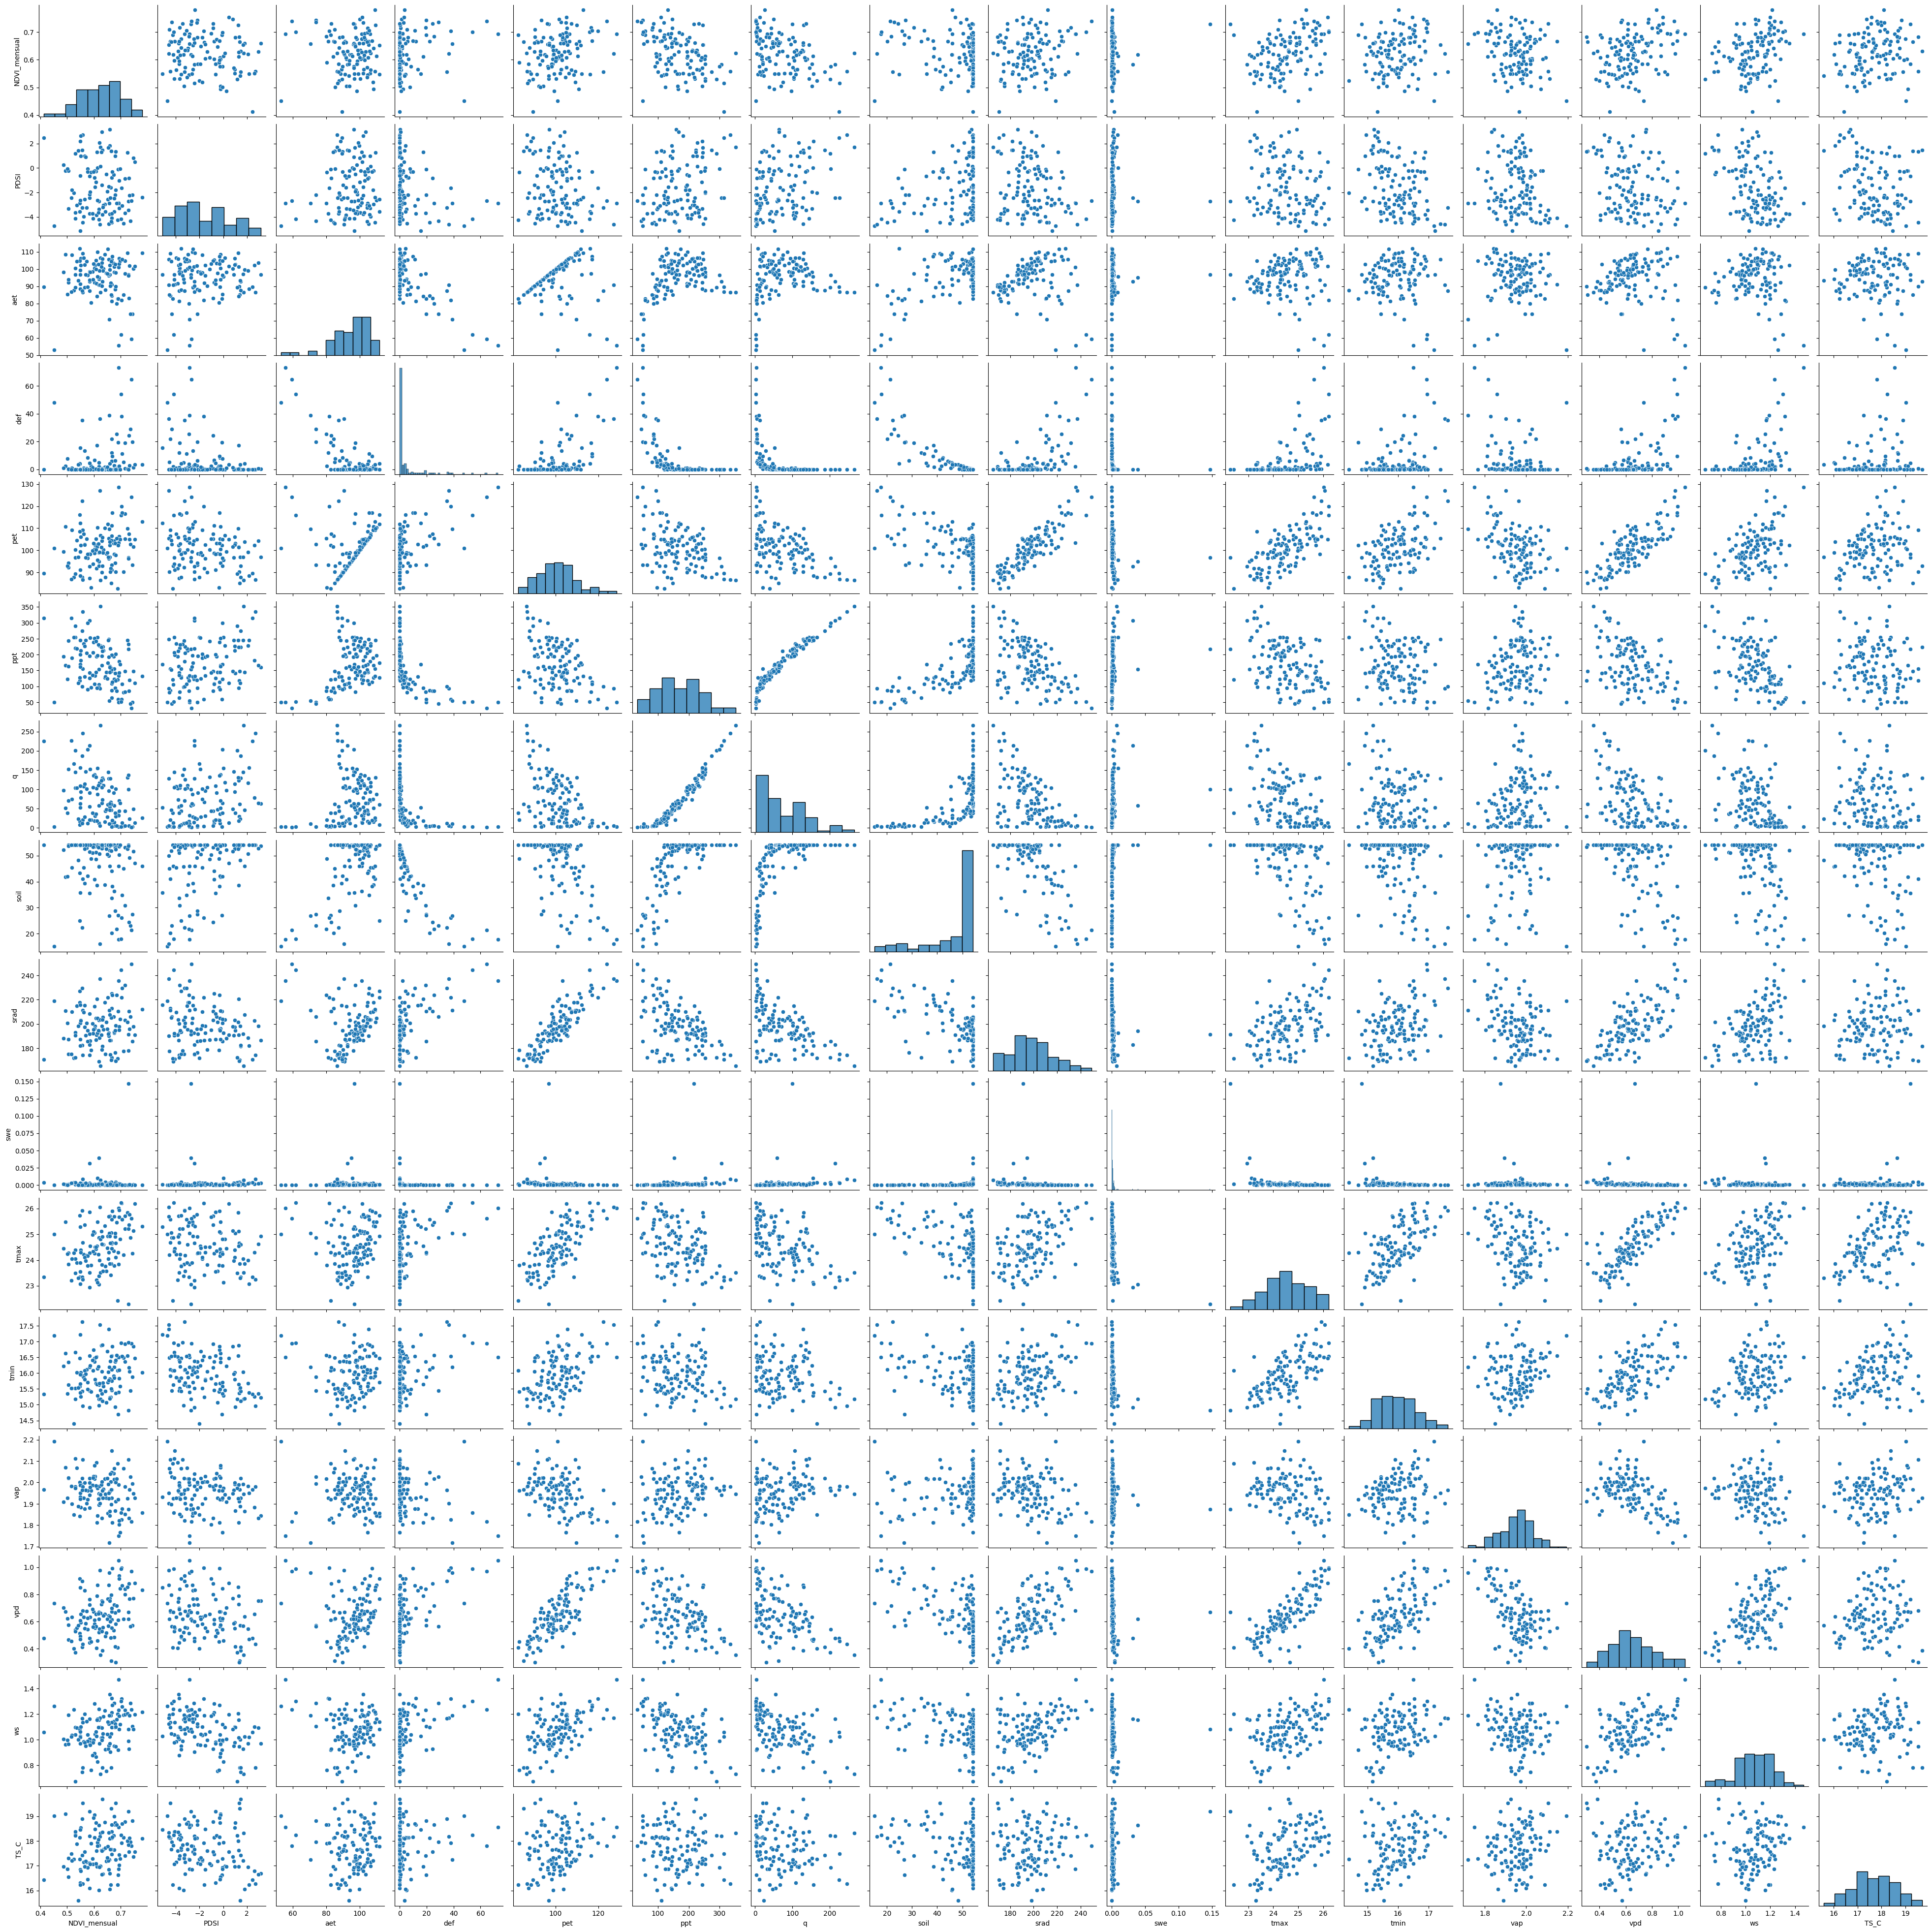

In [77]:
df_numC = df_caldas_union.select_dtypes(include='number')
g = sns.pairplot(df_numC)
g.fig.savefig("pairplot_caldas.png", dpi=300, bbox_inches="tight")
plt.show()

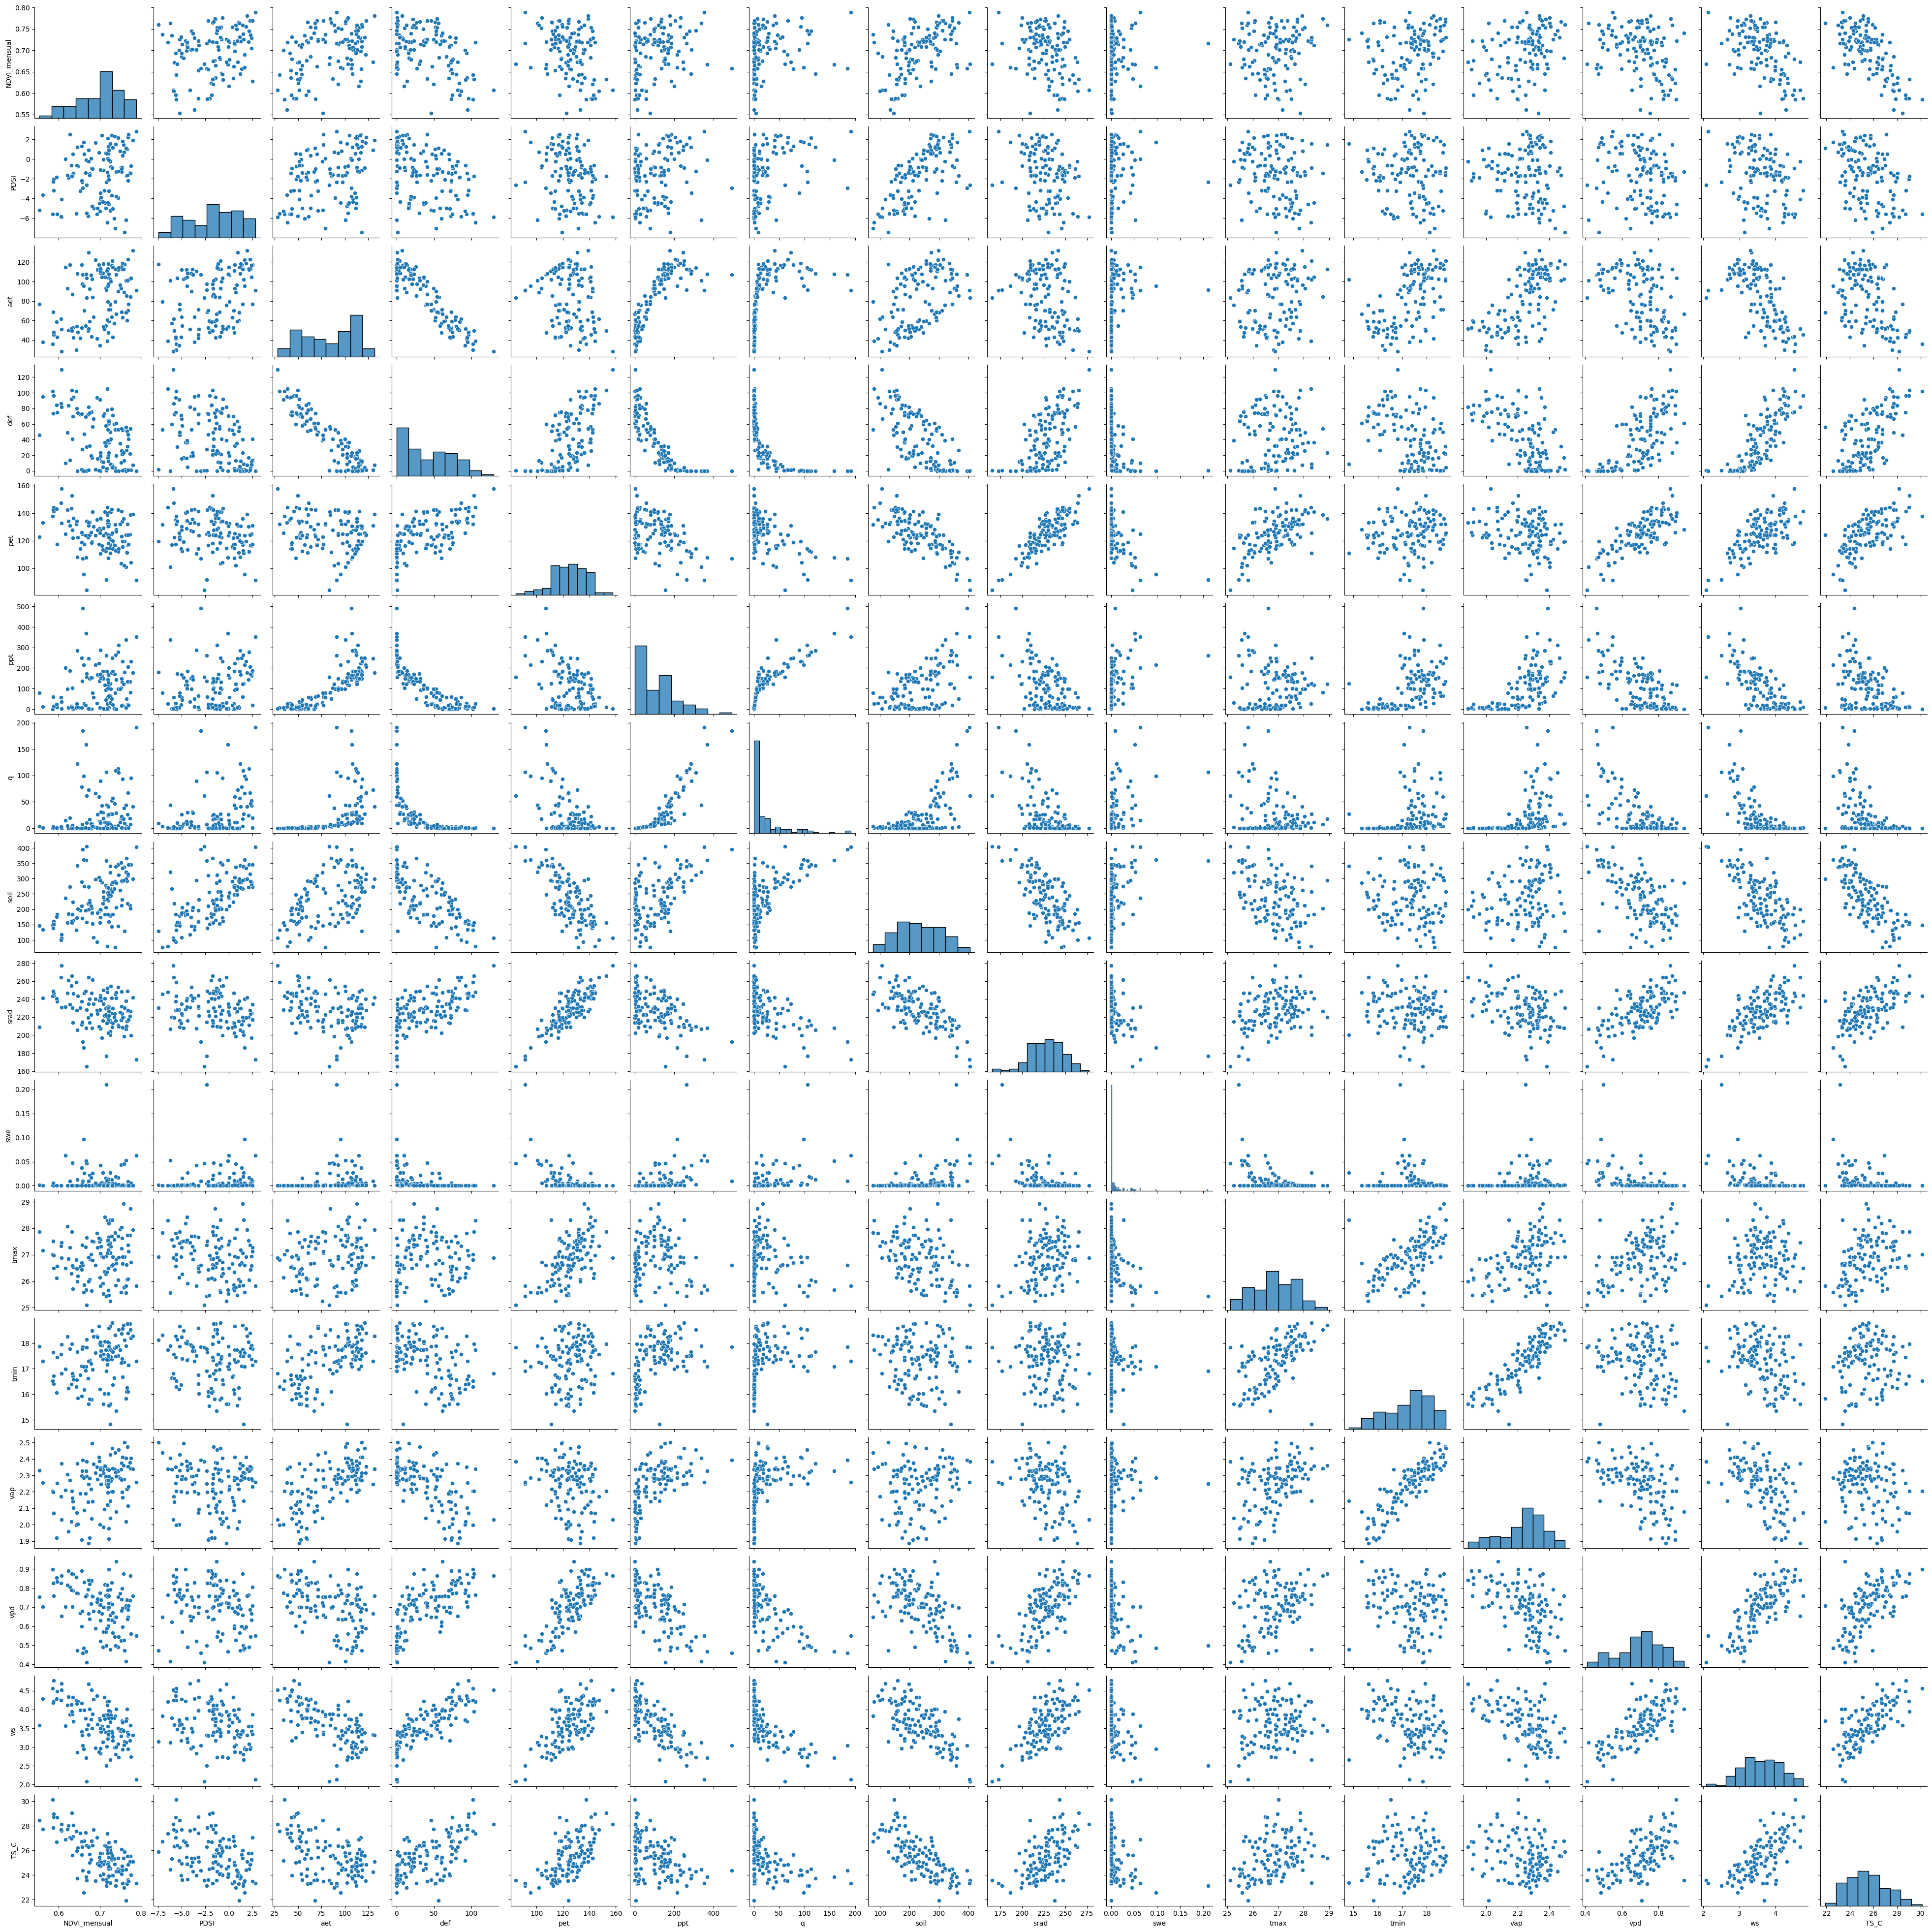

In [78]:
df_numC = df_sierra_union.select_dtypes(include='number')
g = sns.pairplot(df_numC)
g.fig.savefig("pairplot_sierra.png", dpi=300, bbox_inches="tight")
plt.show()

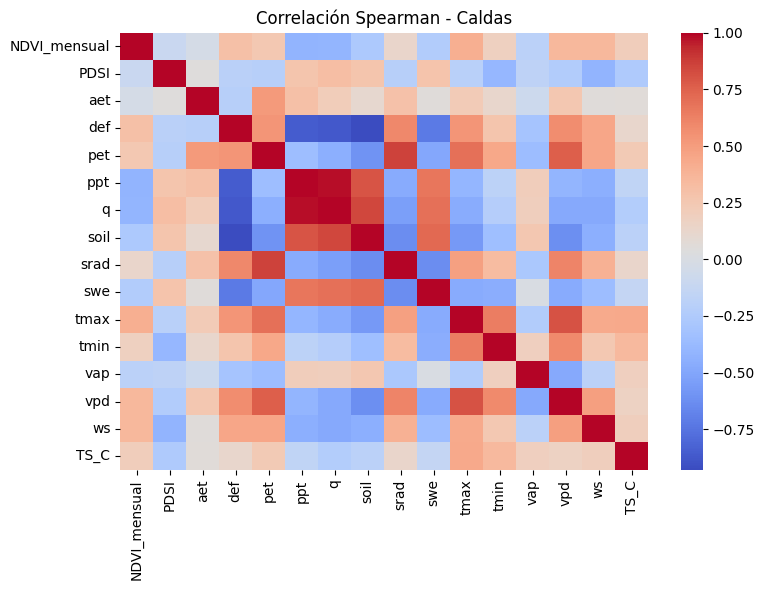

In [79]:
fig, ax = plt.subplots(figsize=(8,6))

sns.heatmap(df_caldas_union.corr(method='spearman', numeric_only=True),
            annot=False,
            cmap='coolwarm',
            ax=ax)

ax.set_title('Correlación Spearman - Caldas')

plt.tight_layout()
plt.show()

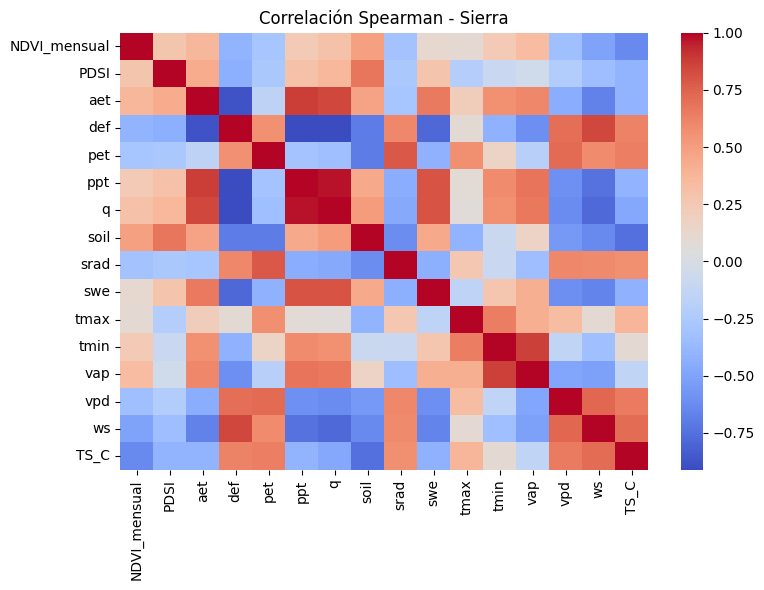

In [80]:
fig, ax = plt.subplots(figsize=(8,6))

sns.heatmap(df_sierra_union.corr(method='spearman', numeric_only=True),
            annot=False,
            cmap='coolwarm',
            ax=ax)

ax.set_title('Correlación Spearman - Sierra')

plt.tight_layout()
plt.show()